In [1]:
# seq = iaa.Sequential([
#     iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
#     iaa.Fliplr(0.5), # horizontally flip 50% of the images
#     iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
# ])

# for batch_idx in range(1000):
#     # 'images' should be either a 4D numpy array of shape (N, height, width, channels)
#     # or a list of 3D numpy arrays, each having shape (height, width, channels).
#     # Grayscale images must have shape (height, width, 1) each.
#     # All images must have numpy's dtype uint8. Values are expected to be in
#     # range 0-255.
#     images = load_batch(batch_idx)
#     images_aug = seq(images=images)
#     train_on_images(images_aug)

In [2]:
import numpy as np
import imgaug as ia
# import imgaug.augmenters as iaa
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imread
# from imgaug import augmenters as iaa
import scipy
import scipy.misc

In [3]:
def _show(img): 
    plt.imshow(img)
    plt.show()

In [4]:
import imgaug.augmenters as iaa
ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array([ia.quokka(size=(64, 64)) for _ in range(32)],dtype=np.uint8)
# print(images.shape)
# _show(images[15])
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0, 0.5))),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5),per_channel = True),   # thêm noise và thêm channel (màu)
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformatiquokkaons to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},   # cắt quay, random theo thứ tự 
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-25, 25),
                    shear=(-8, 8)
                )], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)

In [5]:
import imgaug.augmenters as iaa
aug = iaa.LinearContrast((0.4, 1.6))

In [6]:
images_aug.shape 

(32, 64, 64, 3)

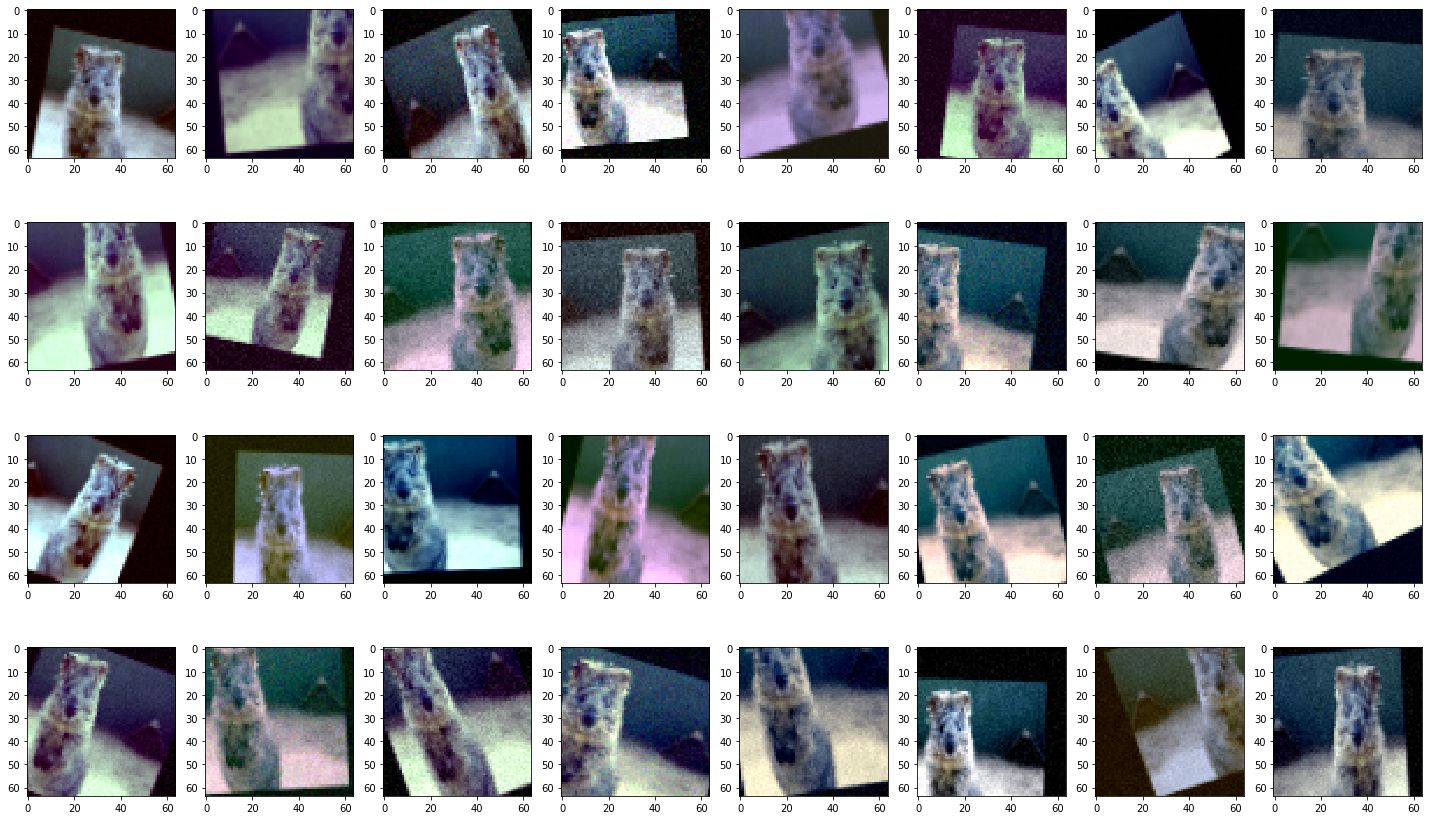

In [7]:
plt.figure (figsize =(25,15))
for i in range(images_aug.shape[0]): 
    plt.subplot(4,8, i + 1) 
    plt.imshow(images_aug[i-1])
#     plt.show()

### Heavy Augmentations

In [8]:
ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

images_aug = seq(images=images)

In [9]:
images_aug.shape

(32, 64, 64, 3)

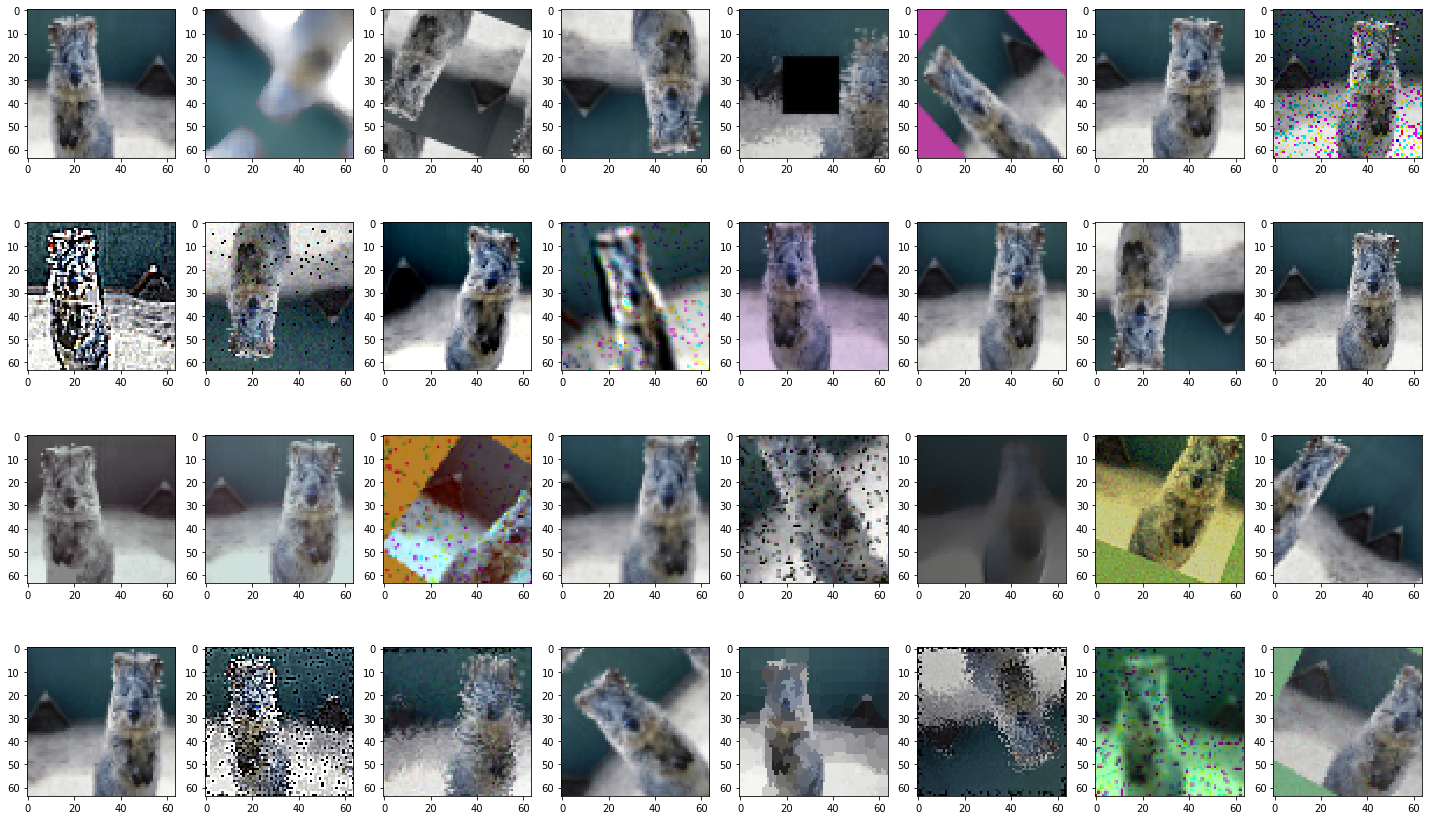

In [10]:
plt.figure(figsize= (25,15))
for i in range(images_aug.shape[0]): 
    plt.subplot(4,8,i+1)
    plt.imshow(images_aug[i-1])

### Bắt các điểm trong img

In [85]:
path_folder = "/home/manhduy/Documents/model_DL/envData_Augmentation/data_augmentation/images/image5.jpg"

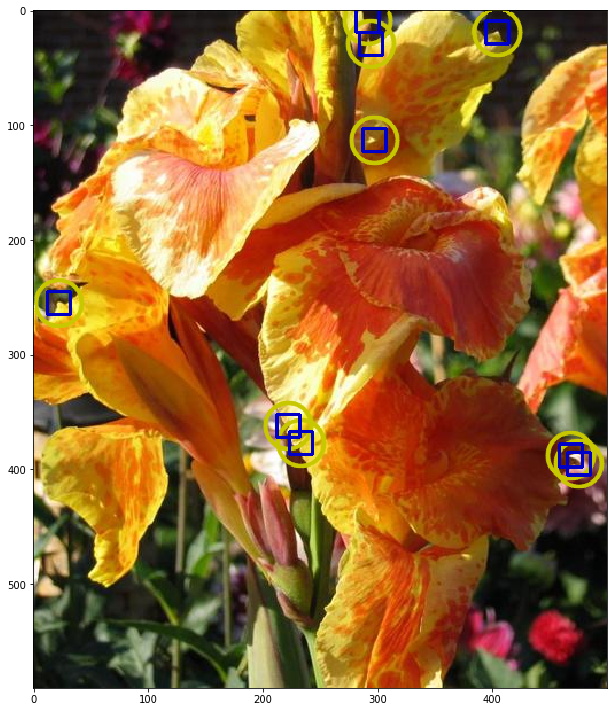

ValueError: Expected y_min for bbox (0.562, -0.001692047377326565, 0.602, 0.032148900169204735, 1.0) to be in the range [0.0, 1.0], got -0.001692047377326565.

In [86]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt


def visualize(image, keypoints, bboxes):
    overlay = image.copy()
    for kp in keypoints:
        cv2.circle(overlay, (int(kp[0]), int(kp[1])), 20, (0, 200, 200), thickness=2, lineType=cv2.LINE_AA)

    for box in bboxes:
        cv2.rectangle(overlay, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (200, 0, 0), thickness=2)

    return overlay


def main():
    image = cv2.imread(path_folder)   # đường dẫn ảnh 

    keypoints = cv2.goodFeaturesToTrack(
        cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), maxCorners=100, qualityLevel=0.5, minDistance=5
    ).squeeze(1)

    bboxes = [(kp[0] - 10, kp[1] - 10, kp[0] + 10, kp[1] + 10) for kp in keypoints]

    disp_image = visualize(image, keypoints, bboxes)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(disp_image, cv2.COLOR_RGB2BGR))
    plt.tight_layout()
    plt.show()

    aug = A.Compose(
        [A.ShiftScaleRotate(scale_limit=0.1, shift_limit=0.2, rotate_limit=10, always_apply=True)],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_labels"]),
        keypoint_params=A.KeypointParams(format="xy"),
    )

    for _i in range(10):
        data = aug(image=image, keypoints=keypoints, bboxes=bboxes, bbox_labels=np.ones(len(bboxes)))

        aug_image = data["image"]
        aug_image = visualize(aug_image, data["keypoints"], data["bboxes"])

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    main()

In [ ]:
aug = get_aug([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedBBoxSafeCrop(width=448, height=336, erosion_rate=0.2),
    A.RGBShift(p=0.5),
    A.Blur(blur_limit=11, p=0.5),
    A.RandomBrightness(p=0.5),
    A.CLAHE(p=0.5),
])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

### This notebook explains how to use albumentations for segmentation

https://www.kaggle.com/c/tgs-salt-identification-challenge

In [52]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [102]:
def visualize_a(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        
    

In [109]:
fps_path1 = "/home/manhduy/Documents/model_DL/envData_Augmentation/data_augmentation/images/kaggle_salt/0fea4b5049_image.png"
fps_path2 = "/home/manhduy/Documents/model_DL/envData_Augmentation/data_augmentation/images/kaggle_salt/0fea4b5049.png"

In [132]:
image = cv2.imread(fps_path1)
mask = cv2.imread(fps_path2,0)

In [133]:
x = np.resize(image,(400,400))

### Original image <a class="anchor" id="original-image"></a>

In [134]:
print(image.shape, mask.shape)

(101, 101, 3) (101, 101)


In [135]:
original_height, original_width = image.shape[:2]

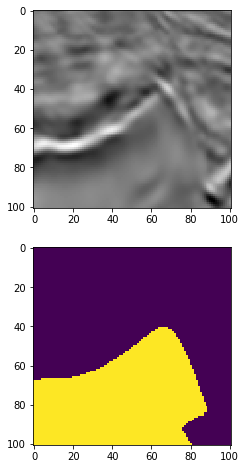

In [136]:
visualize_a(image, mask)

# Padding

 UNet type architecture require input image size be divisible by $2^N$, where $N$ is th enumber of the maxpooling layers. In the vanilla UNet $N=5$  $\Longrightarrow$ we need to pad input images to the closest divisible by $2^5 = 32$ number which is 128. This operation may be performed using [**PadIfNeeded**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.PadIfNeeded) transformation. Which pads both image and mask on all four sides. Padding type (zero, constant, reflection) may be specified. Default padding is reflection padding.

(128, 128, 3) (128, 128)


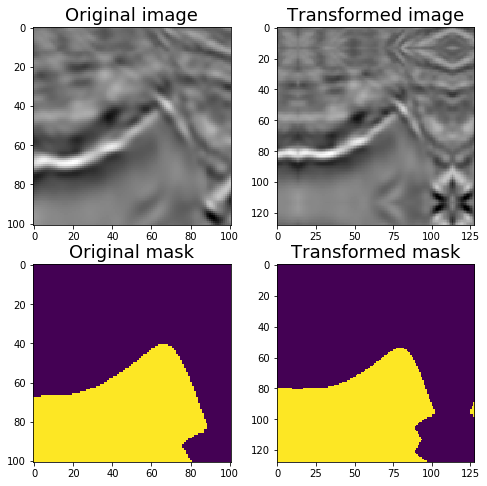

In [137]:
aug = PadIfNeeded(p=1, min_height=128, min_width=128)

augmented = aug(image=image, mask=mask)

image_padded = augmented['image']
mask_padded = augmented['mask']

print(image_padded.shape, mask_padded.shape)

visualize_a(image_padded, mask_padded, original_image=image, original_mask=mask)

### CenterCrop and Crop

To get to the original image and mask we may use [**CenterCrop**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CenterCrop) or [**Crop**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Crop) transformations.

(128, 128, 3) (128, 128)


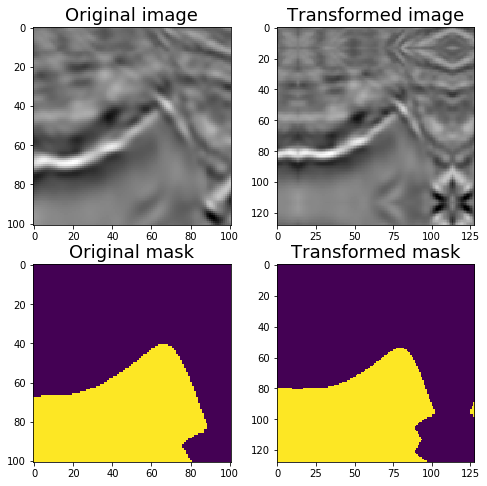

In [142]:
aug = PadIfNeeded(p=1, min_height=128, min_width=128)

augmented = aug(image=image, mask=mask)

image_padded = augmented['image']
mask_padded = augmented['mask']

print(image_padded.shape, mask_padded.shape)

visualize_a(image_padded, mask_padded, original_image=image, original_mask=mask)

dict_keys(['image', 'mask'])
(101, 101, 3) (101, 101)


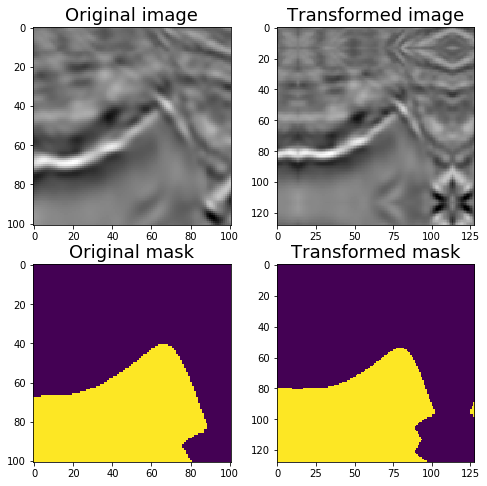

In [147]:
aug = CenterCrop(p=1, height=original_height, width=original_width)

augmented = aug(image=image_padded, mask=mask_padded)
print(augmented.keys())

image_center_cropped = augmented['image']
mask_center_cropped = augmented['mask']

print(image_center_cropped.shape, mask_center_cropped.shape)

assert (image - image_center_cropped).sum() == 0
assert (mask - mask_center_cropped).sum() == 0

visualize_a(image_padded, mask_padded, original_image=image_center_cropped, original_mask=mask_center_cropped)

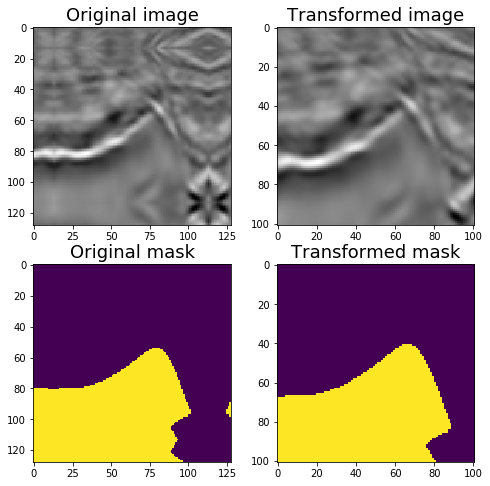

In [150]:
x_min = (128 - original_width) // 2
y_min = (128 - original_height) // 2

x_max = x_min + original_width
y_max = y_min + original_height
# print(original_width)
aug = Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

augmented = aug(image=image_padded, mask=mask_padded)

image_cropped = augmented['image']
mask_cropped = augmented['mask']

# print(image_cropped.shape, mask_cropped.shape)
# print(image_cropped.shape)


assert (image - image_cropped).sum() == 0
assert (mask - mask_cropped).sum() == 0

visualize_a(image_cropped, mask_cropped, original_image=image_padded, original_mask=mask_padded)

##  Non destructive transformations. [Dehidral group D4](https://en.wikipedia.org/wiki/Dihedral_group)

For images for which there is no clear notion of top like this one, satellite and aerial imagery or medical imagery it is typically a good idea to add transformations that do not add or loose the information.

There are eight distinct ways to represent the same square on the plane.

![D4](https://habrastorage.org/webt/ln/nw/nc/lnnwncjfjsn8zpfo6igvqq-rjky.png)

Combinations of the transformations [HorizontalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.HorizontalFlip), [VerticalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.VerticalFlip), [Transpose](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Transpose), [RandomRotate90](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomRotate90) will be able to get the original image to all eight states.

###  HorizontalFlip

<bound method BasicTransform.get_params of HorizontalFlip(always_apply=False, p=1)>


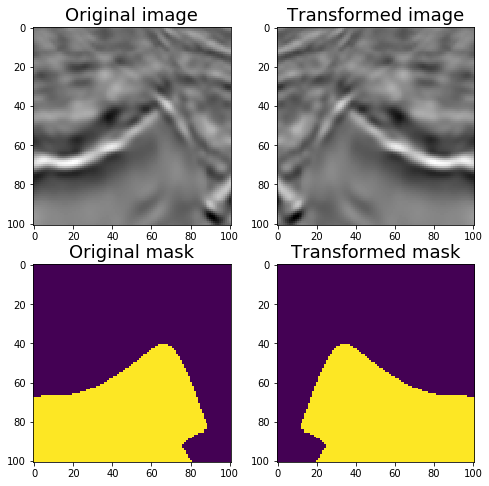

In [155]:
aug = HorizontalFlip(p=1)

print(aug.get_params)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize_a(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

### VerticalFlip

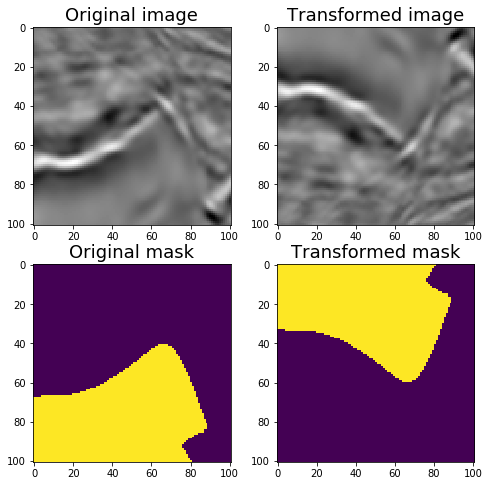

In [157]:
aug = VerticalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize_a(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)

### RandomRotate90 (Randomly rotates by 0, 90, 180, 270 degrees)

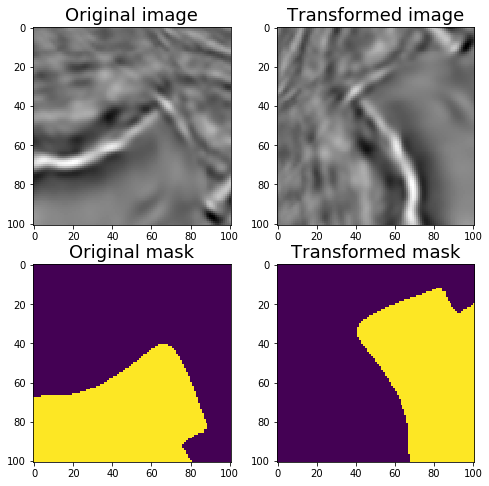

In [159]:
aug = RandomRotate90(p=1)

augmented = aug(image=image, mask=mask)

image_rot90 = augmented['image']
mask_rot90 = augmented['mask']

visualize_a(image_rot90, mask_rot90, original_image=image, original_mask=mask)

### Transpose (switch X and Y axis)

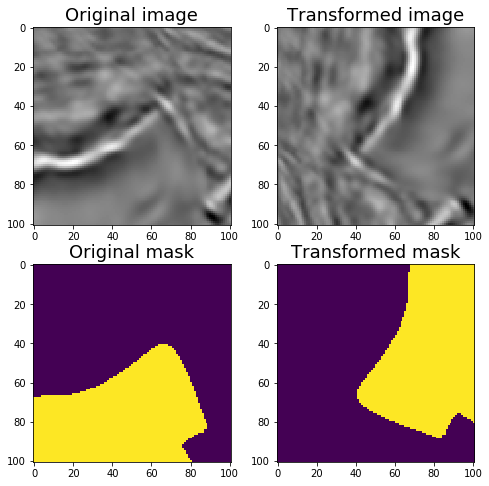

In [163]:
aug = Transpose(p=1)

augmented = aug(image=image, mask=mask)

image_transposed = augmented['image']
mask_transposed = augmented['mask']

visualize_a(image_transposed, mask_transposed, original_image=image, original_mask=mask)

### Non-rigid transformations: ElasticTransform, GridDistortion, OpticalDistortion


 In medical imaging problems non rigind transformations help to augment the data. It is unclear if they will help in this problem, but let's look at them. We will consider [ElasticTransform](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.ElasticTransform), [GridDistortion](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.GridDistortion), [OpticalDistortion](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.OpticalDistortion).

### ElasticTransform

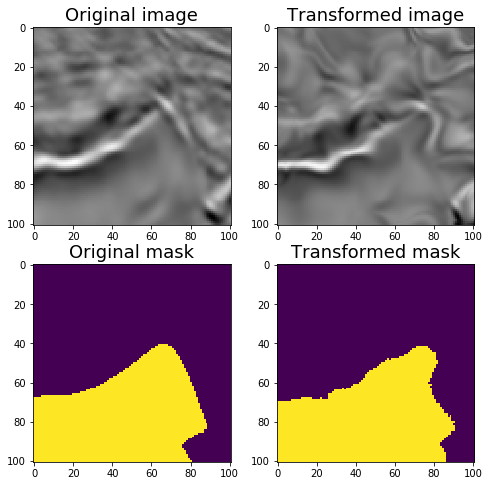

In [164]:
aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

visualize_a(image_elastic, mask_elastic, original_image=image, original_mask=mask)

### GridDistortion

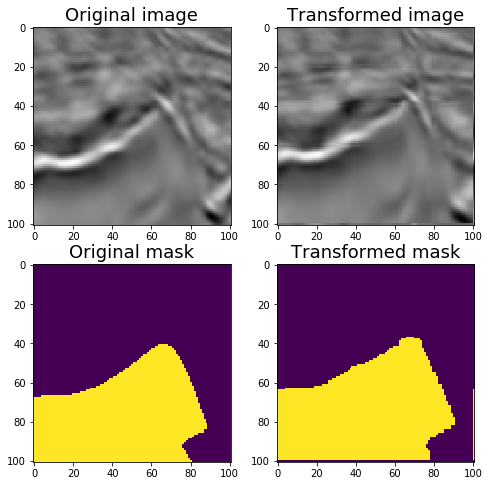

In [175]:
aug = GridDistortion(p=1)

augmented = aug(image=image, mask=mask)

image_grid = augmented['image']
mask_grid = augmented['mask']

visualize_a(image_grid, mask_grid, original_image=image, original_mask=mask)

### OpticalDistortion

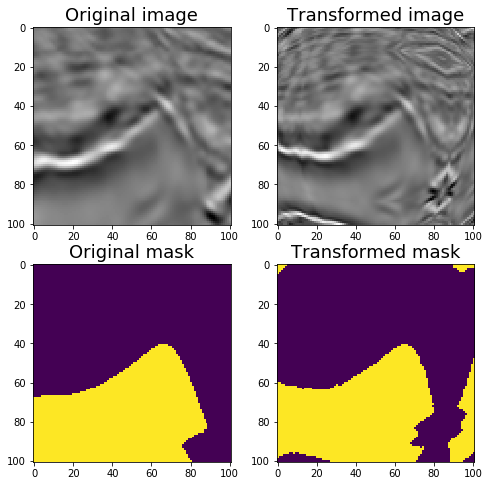

In [176]:
aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)

augmented = aug(image=image, mask=mask)

image_optical = augmented['image']
mask_optical = augmented['mask']

visualize_a(image_optical, mask_optical, original_image=image, original_mask=mask)

### RandomSizedCrop

One may combine [RandomCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomCrop) and [RandomScale](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomScale) but there is a transformation [RandomSizedCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomSizedCrop) that allows to combine them into one transformation.

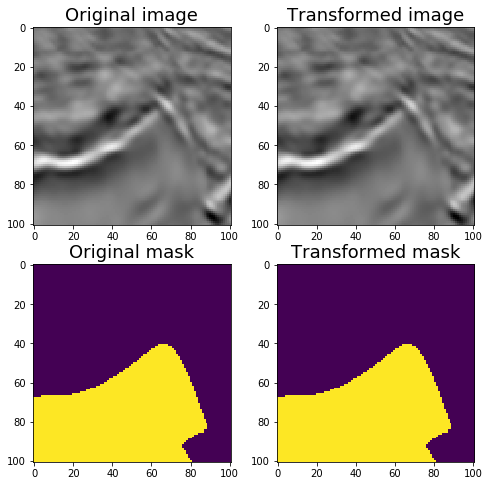

In [178]:
aug = RandomSizedCrop(p=1, min_max_height=(50, 101), height=original_height, width=original_width)

augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']

visualize_a(image_scaled, mask_scaled, original_image=image, original_mask=mask)

### Let's try to combine different transformations

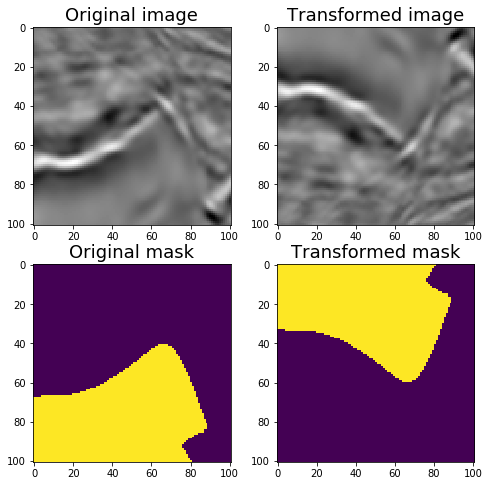

In [180]:
aug = Compose([VerticalFlip(p=0.5),              
              RandomRotate90(p=0.5)])

augmented = aug(image=image, mask=mask)

image_light = augmented['image']
mask_light = augmented['mask']

visualize_a(image_light, mask_light, original_image=image, original_mask=mask)

## Let's add non rigid transformations and RandomSizedCrop

### Medium augmentations

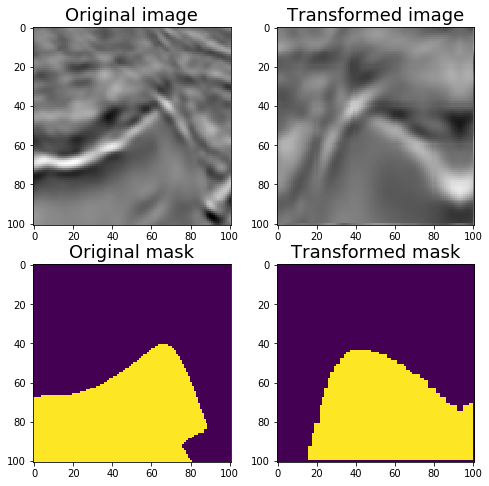

In [181]:
aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
          PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)], p=1),    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=1, shift_limit=0.5)                  
        ], p=0.8)])

augmented = aug(image=image, mask=mask)

image_medium = augmented['image']
mask_medium = augmented['mask']

visualize_a(image_medium, mask_medium, original_image=image, original_mask=mask)

### Let's add non-spatial stransformations

 Many non spatial transformations like [CLAHE](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CLAHE), [RandomBrightness](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomBrightness), [RandomContrast](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomContrast), [RandomGamma](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomGamma) can be also added. They will be applied only to the image and not the mask.

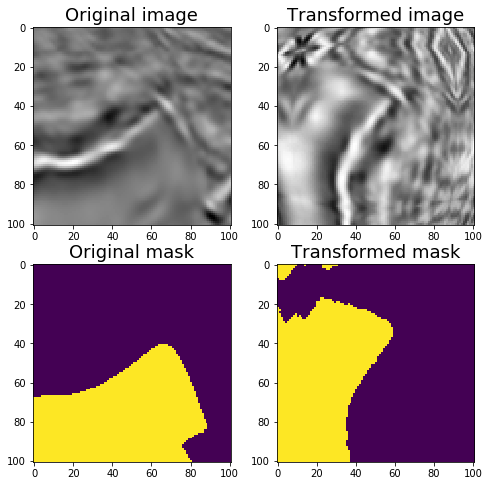

In [182]:
aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
          PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)], p=1),    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])

augmented = aug(image=image, mask=mask)

image_heavy = augmented['image']
mask_heavy = augmented['mask']

visualize_a(image_heavy, mask_heavy, original_image=image, original_mask=mask)